In [1]:
## Generate inital results
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.animation as animation
import scipy.io as scio

from dolfin import *
from fenics import *
import warnings

# %%
# Geubelle research group
# Authors:  Qibang Liu (qibang@illinois.edu)
#           Michael Zakoworotny (mjz7@illinois.edu)
#           Philippe Geubelle (geubelle@illinois.edu)
#           Aditya Kumar (aditya.kumar@ce.gatech.edu)
#
# An example of running the FP solver for DCPD

import os
from solver_FP import FP_solver
from kinetics_library import Prout_Tompkins_Diffusion
from postProcess_FP import Post_process, saveResults, loadResults


# Sam's imports
from scipy import interpolate as itp
from scipy.integrate import quad
from scipy import optimize


# Switch to current directory
try:
    os.chdir(os.path.dirname(__file__))
except:
    print("Cannot switch directories")

# Thermo-chemical properties
kr = 0.15      # thermal conductivity, W/m-K
rhor = 980.0    # density, kg/m^3
Cpr = 1600.0    # specific heat, J/kg-K

# Nature values
Hr = 350000    # enthalpy, J/kg
A_ = 8.55e15    # pre-exponential constant, 1/s
Er = 110750.0   # activation energy J/mol
n = 1.72        # cure kinetics parameter
m = 0.77        # cure kinetics parameter
Ca = 14.48      # cure kinetics parameter
alpha_c = 0.41  # cure kinetics parameter

# Create an object for the cure kinetics model
ptd_model = Prout_Tompkins_Diffusion(n, m, Ca, alpha_c)

# Initial conditions for temperature and degree of cure
T0 = 20         # deg C
alpha0 = 0.01

# Length of domain
L = 0.03

# Initialize the solver with the parameters
solver = FP_solver(kr, rhor, Cpr, Hr, A_, Er,
                   ptd_model, T0, alpha0, 0, 0.001, 0, L=L)

# Run the solver until 10 s
t_end = 150
results_data = solver.solve(
    t_end, outputFreq_t=10, outputFreq_x=1)

# %%
# Post-process - generate report, compute the front speed, and save an animation of the temperature and alpha fronts

save_dir = "out_DCPD"  # path to save the result files.
pts_ = [2e-3, 5e-3]  # Get evolution of alpha and T at this points
# create post process object
post_pro = Post_process(results_data, solver, pts=pts_,
                        save_dir=save_dir, save_suffix="DCPD", anim_frames=100, fid=0)
post_pro.generateReport()  # generate report

# %%
# Pack the results for future use
saveResults(results_data, save_dir, "data_DCPD")  # save to .mat file
loadedResults = loadResults(save_dir, "data_DCPD")  # load from .mat file
results_data = loadedResults

Cannot switch directories
Saving results for t = 0.010000 s, Elapsed simulation time: 0.075366 s
Saving results for t = 0.020000 s, Elapsed simulation time: 0.151757 s
Saving results for t = 0.030000 s, Elapsed simulation time: 0.229094 s
Saving results for t = 0.040000 s, Elapsed simulation time: 0.303347 s
Saving results for t = 0.050000 s, Elapsed simulation time: 0.421201 s
Saving results for t = 0.060000 s, Elapsed simulation time: 0.496034 s
Saving results for t = 0.070000 s, Elapsed simulation time: 0.570879 s
Saving results for t = 0.080000 s, Elapsed simulation time: 0.645768 s
Saving results for t = 0.090000 s, Elapsed simulation time: 0.719504 s
Saving results for t = 0.100000 s, Elapsed simulation time: 0.793702 s
Saving results for t = 0.110000 s, Elapsed simulation time: 0.868205 s
Saving results for t = 0.120000 s, Elapsed simulation time: 0.943322 s
Saving results for t = 0.130000 s, Elapsed simulation time: 1.018483 s
Saving results for t = 0.140000 s, Elapsed simulati

KeyboardInterrupt: 

In [2]:
# Load data into results_data
results_data = loadResults(save_dir, "data_DCPD")  # load from .mat file

# Initial temp data. Index doesn't really matter, we shift over later
T=results_data['T_data']
T1=T[300,:]
x=results_data['x_data'][300,:]

# define normalized curve
theta=(T1-np.min(T1))/(np.max(T1)-np.min(T1))

# interpolation function for x_d
alpha_fun = itp.interp1d(theta, x, kind='linear', assume_sorted=False, bounds_error=False, fill_value='extrapolate')
x_d = alpha_fun(0.5)
x_gs = alpha_fun(0.02)
print(x_gs)

# magic shift to get gap at 0, redef x_d
#x-=x_gs
#alpha_fun = itp.interp1d(theta, x, kind='linear', assume_sorted=False, bounds_error=False, fill_value='extrapolate')
#x_d = alpha_fun(0.5)
#x_gs = alpha_fun(0.0001)

# constants!
a=kr/(rhor*Cpr)

0.004825306665967296


Text(0.5, 1.0, 'DCPD Heat Curve Data')

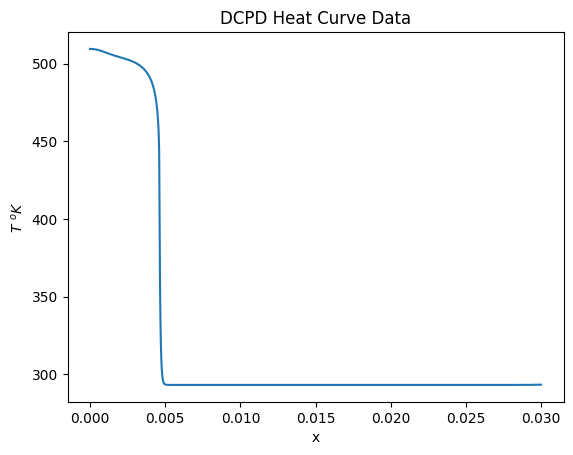

In [3]:
# plot initial curve
plt.plot(x,T1)
plt.xlabel("x")
plt.ylabel(r'$T~^oK$')
plt.title("DCPD Heat Curve Data")

Text(0.5, 1.0, 'Normalized Heat Curve')

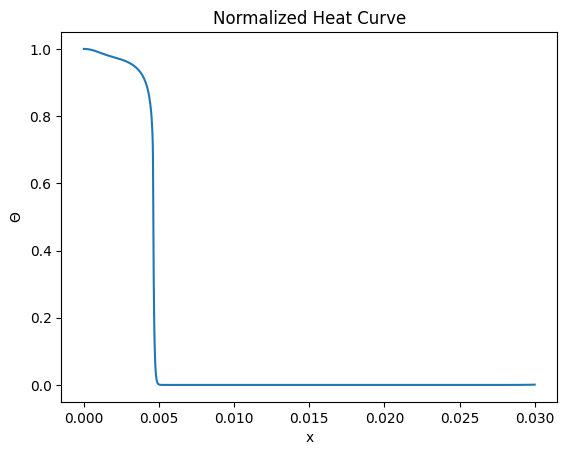

In [4]:
# plot normalized curve
plt.plot(x,theta)
plt.xlabel("x")
plt.ylabel(r"${\Theta}$")
plt.title("Normalized Heat Curve")

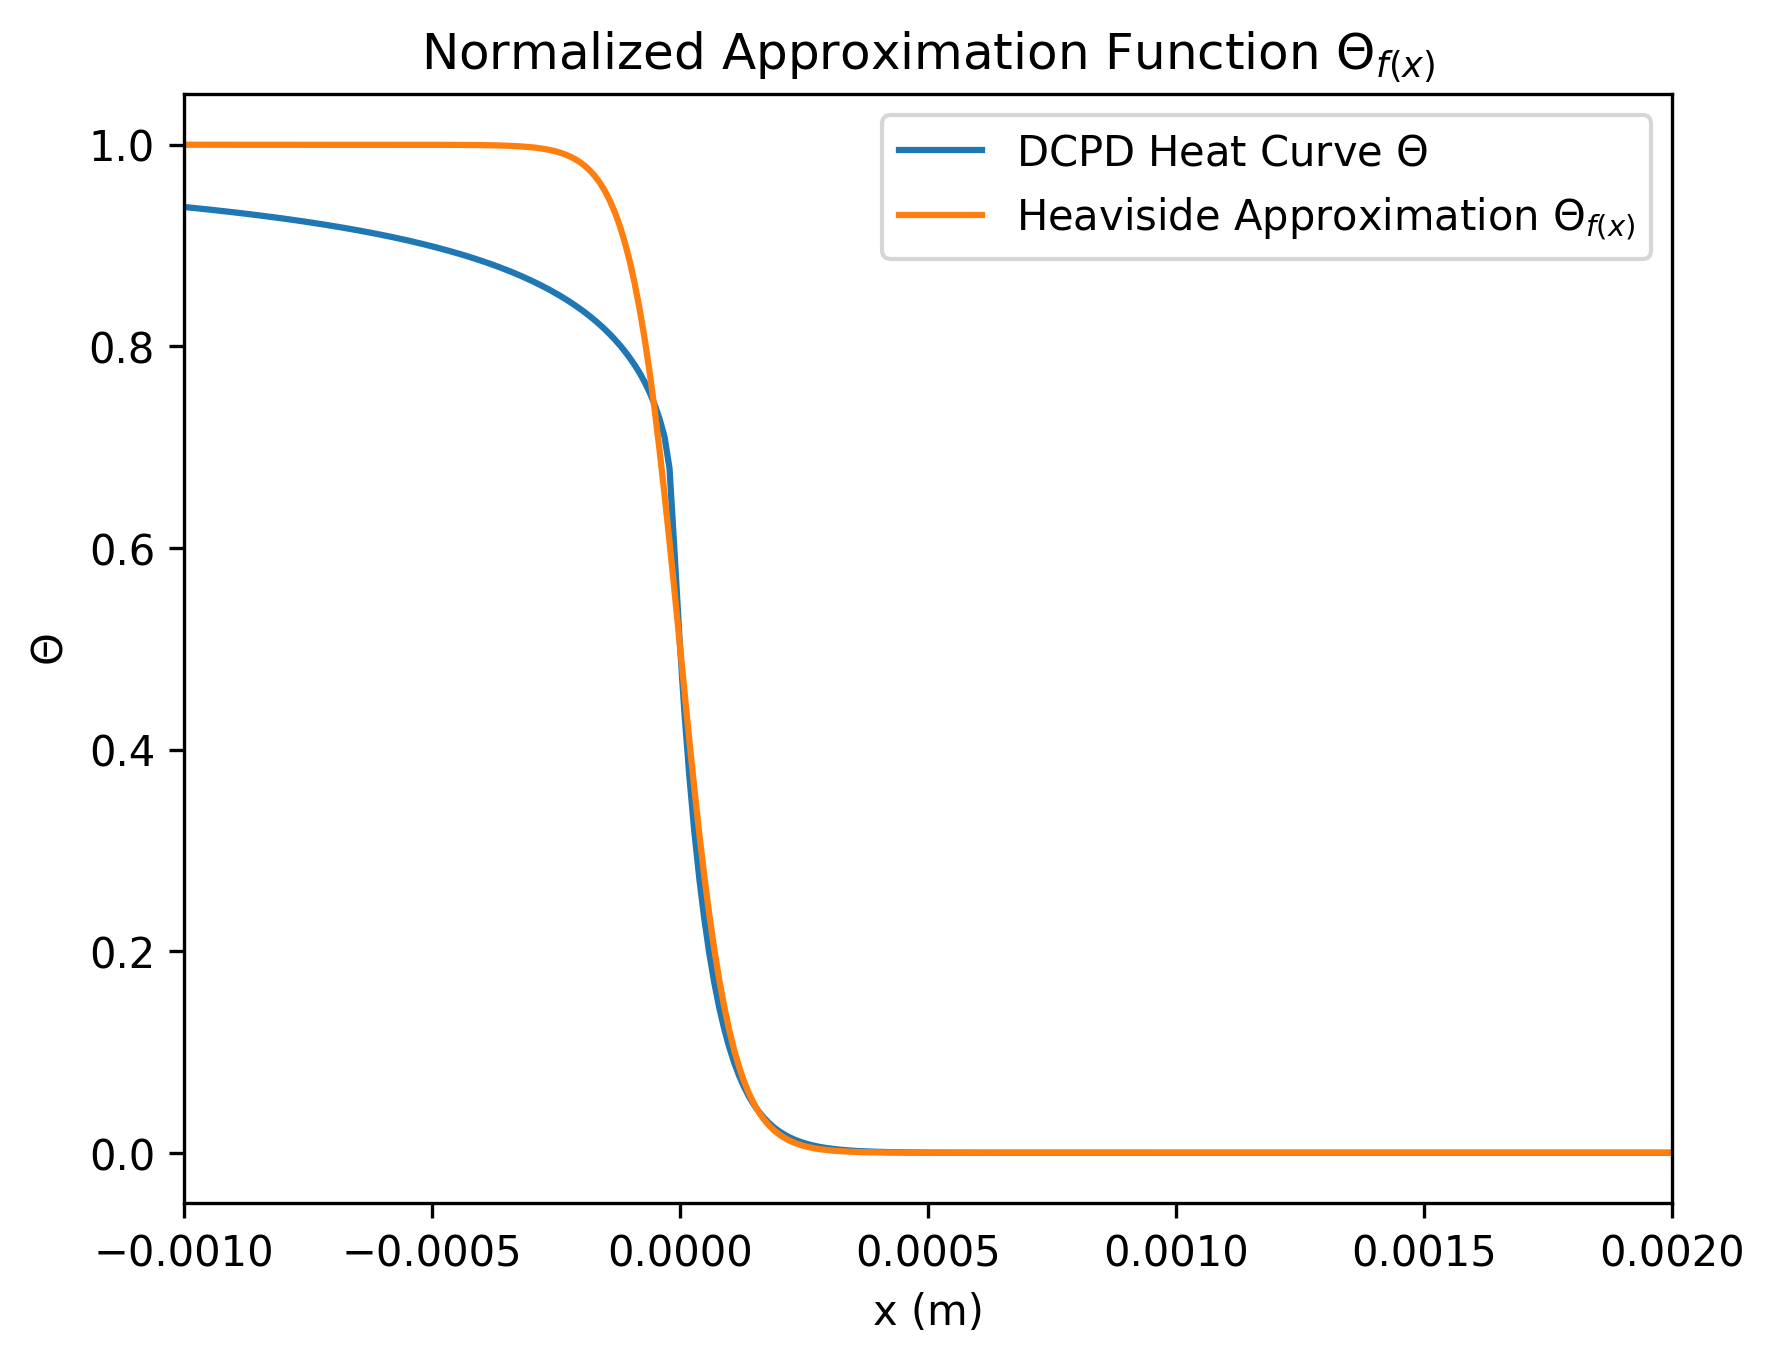

In [58]:
# Tuning initial condition function to FEM data by changing k
k=10000
thetaf = (1/2)*(1+np.tanh(k*(x_d-x)))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.plot(x-x_d,theta,label=r"DCPD Heat Curve ${\Theta}$")
plt.plot(x-x_d,thetaf,label="Heaviside Approximation ${\Theta}_{f(x)}$")
plt.xlabel("x (m)")
plt.xlim(-.001,0.002)
plt.ylabel(r"${\Theta}$")
plt.title(r"Normalized Approximation Function ${\Theta}_{f(x)}$")
plt.legend()

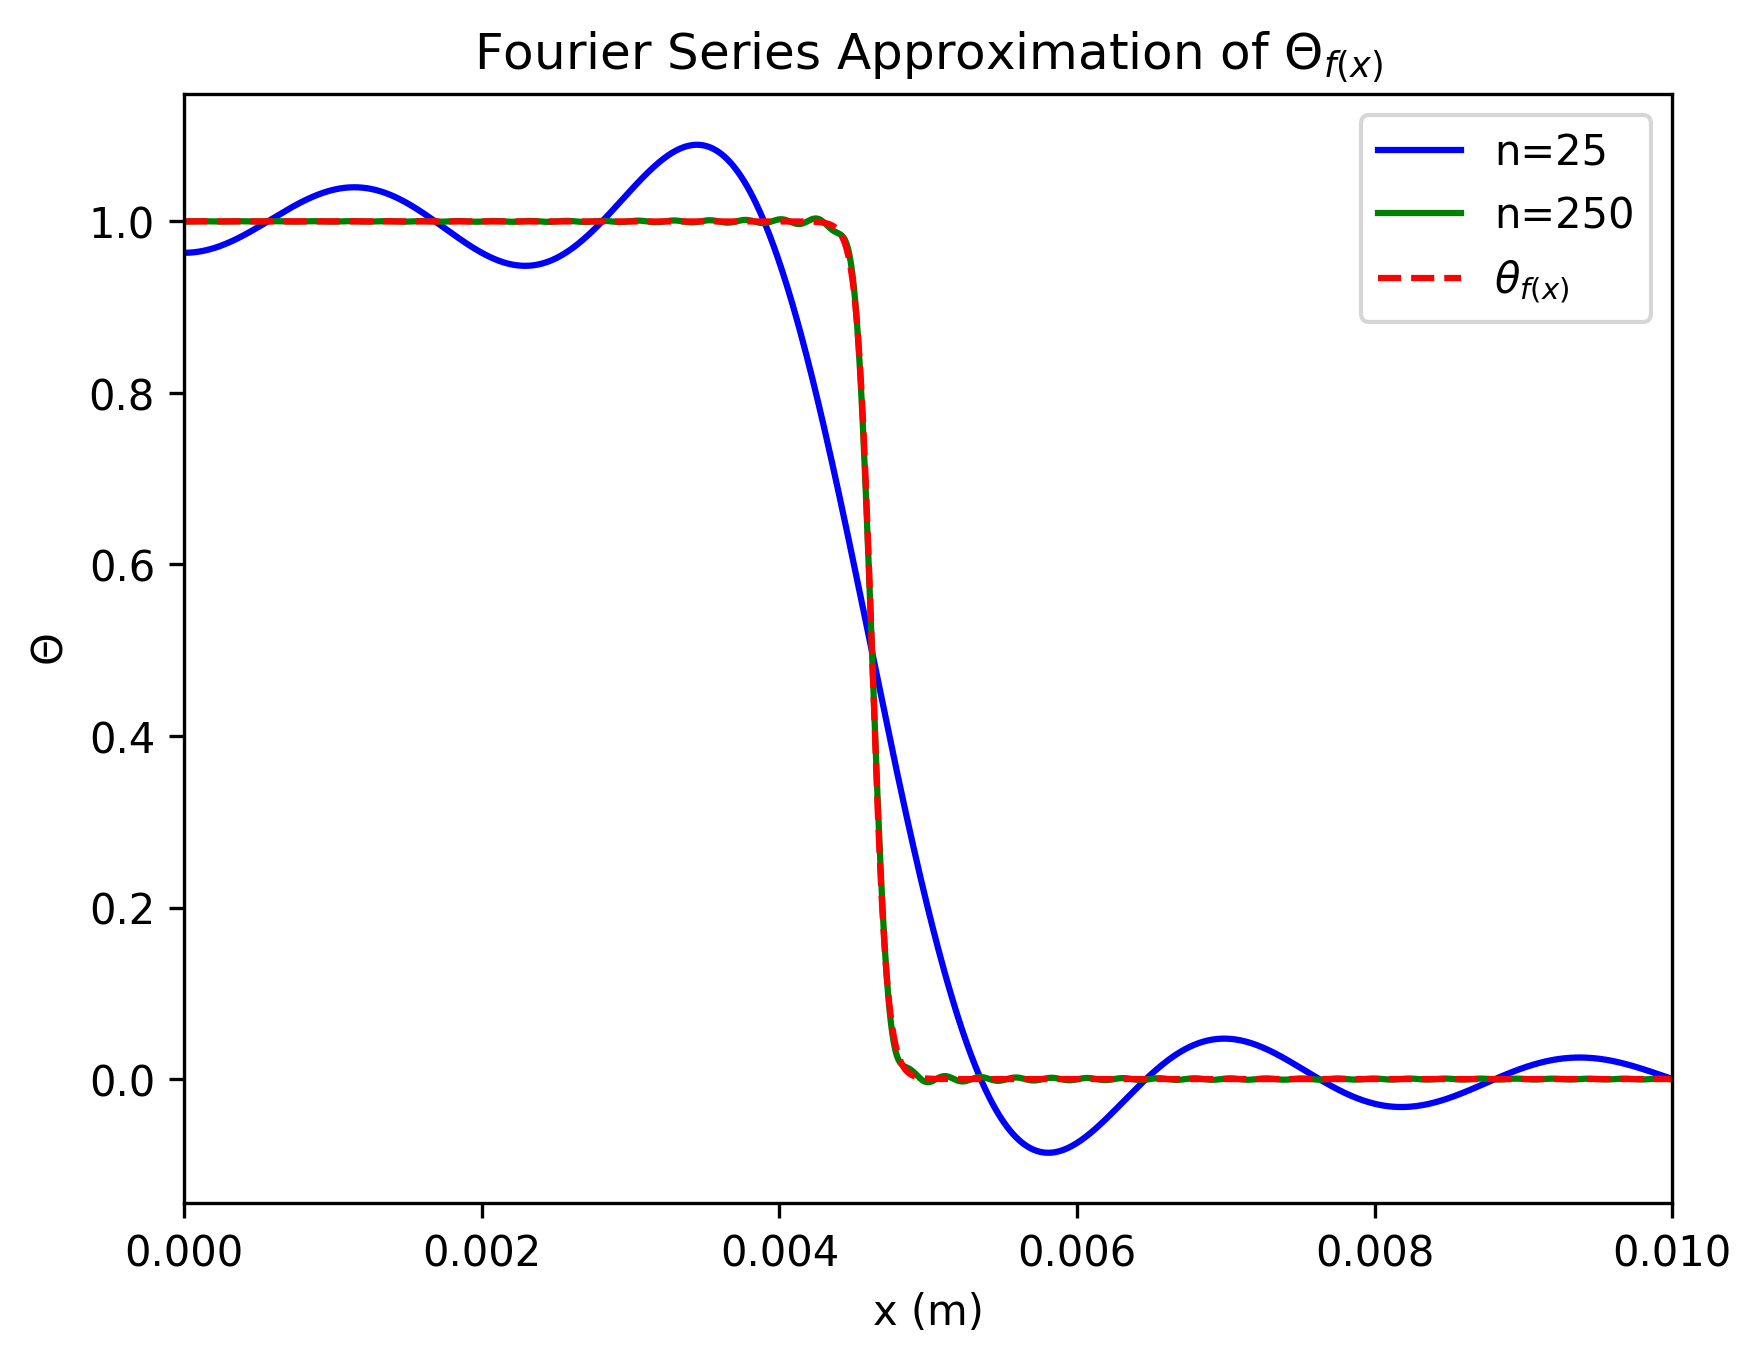

In [6]:
# Calculate Fourier Series coefficients
# define constants / limits
n=25
sum = 0
An = []

# functions as lambdas for scipy to play nice
fx = lambda x:((1/2)*(1+np.tanh(k*(x_d-x))))
fcos = lambda x:((1/2)*(1+np.tanh(k*(x_d-x))))*np.cos((i*np.pi*x)/L)

# For n=25 calculate series
for i in range(n):
    if i == 0.0:
        an=(1/(L)*quad(fx,0.0,2*L)[0])
        An.append(an)
    else:
        an=(2/L)*quad(fcos,0.0,2*L)[0]
        An.append(an)
for i in range(n):
    if i == 0.0:
        sum+=An[i]
    else:
        sum+=An[i]*np.cos((i*x*np.pi)/L)

plt.plot(x,sum,'b',label="n=25")

# reset constants / limits
n = 250
sum = 0
An = []

# for n=250 calculate series
for i in range(n):
    if i == 0.0:
        an=(1/(L)*quad(fx,0.0,2*L)[0])
        An.append(an)
    else:
        an=(2/L)*quad(fcos,0.0,2*L)[0]
        An.append(an)
for i in range(n):
    if i == 0.0:
        sum+=An[i]
    else:
        sum+=An[i]*np.cos((i*x*np.pi)/L)

        
plt.plot(x,sum,'g',label="n=250")
plt.plot(x,thetaf,'r--',label=r"$\theta _{f(x)}$")

# plot n compare
plt.xlim(0,0.010)
plt.xlabel("x (m)")
plt.ylabel(r"${\Theta}$")
plt.title(r"Fourier Series Approximation of ${\Theta}_{f(x)}$")
plt.legend()

3000
2995
3005
[20.13784541 20.12876589 20.12097264 20.11499453 20.10995588]
[236.46720251 236.46835118 236.47172485 ...  20.12097264  20.11499453
  20.10995588]
3000
2995
3005
[20.14771853 20.14771853 20.14771853 20.14771853 20.14771853]
[236.5029296  236.50292894 236.50292697 ...  20.14771853  20.14771853
  20.14771853]
3000
2995
3005
[20.14771853 20.14771853 20.14771853 20.14771853 20.14771853]
[236.47760761 236.47759354 236.47755133 ...  20.14771853  20.14771853
  20.14771853]
3000
2995
3005
[20.14771853 20.14771853 20.14771853 20.14771853 20.14771853]
[236.31826438 236.31820661 236.31803328 ...  20.14771853  20.14771853
  20.14771853]
3000
2995
3005
[20.14771853 20.14771853 20.14771853 20.14771853 20.14771853]
[235.88654082 235.88641552 235.88603958 ...  20.14771853  20.14771853
  20.14771853]
3000
2995
3005
[20.14771853 20.14771853 20.14771853 20.14771853 20.14771853]
[235.10872994 235.10853007 235.10793044 ...  20.14771853  20.14771853
  20.14771853]
109.83899975160858
20.155672

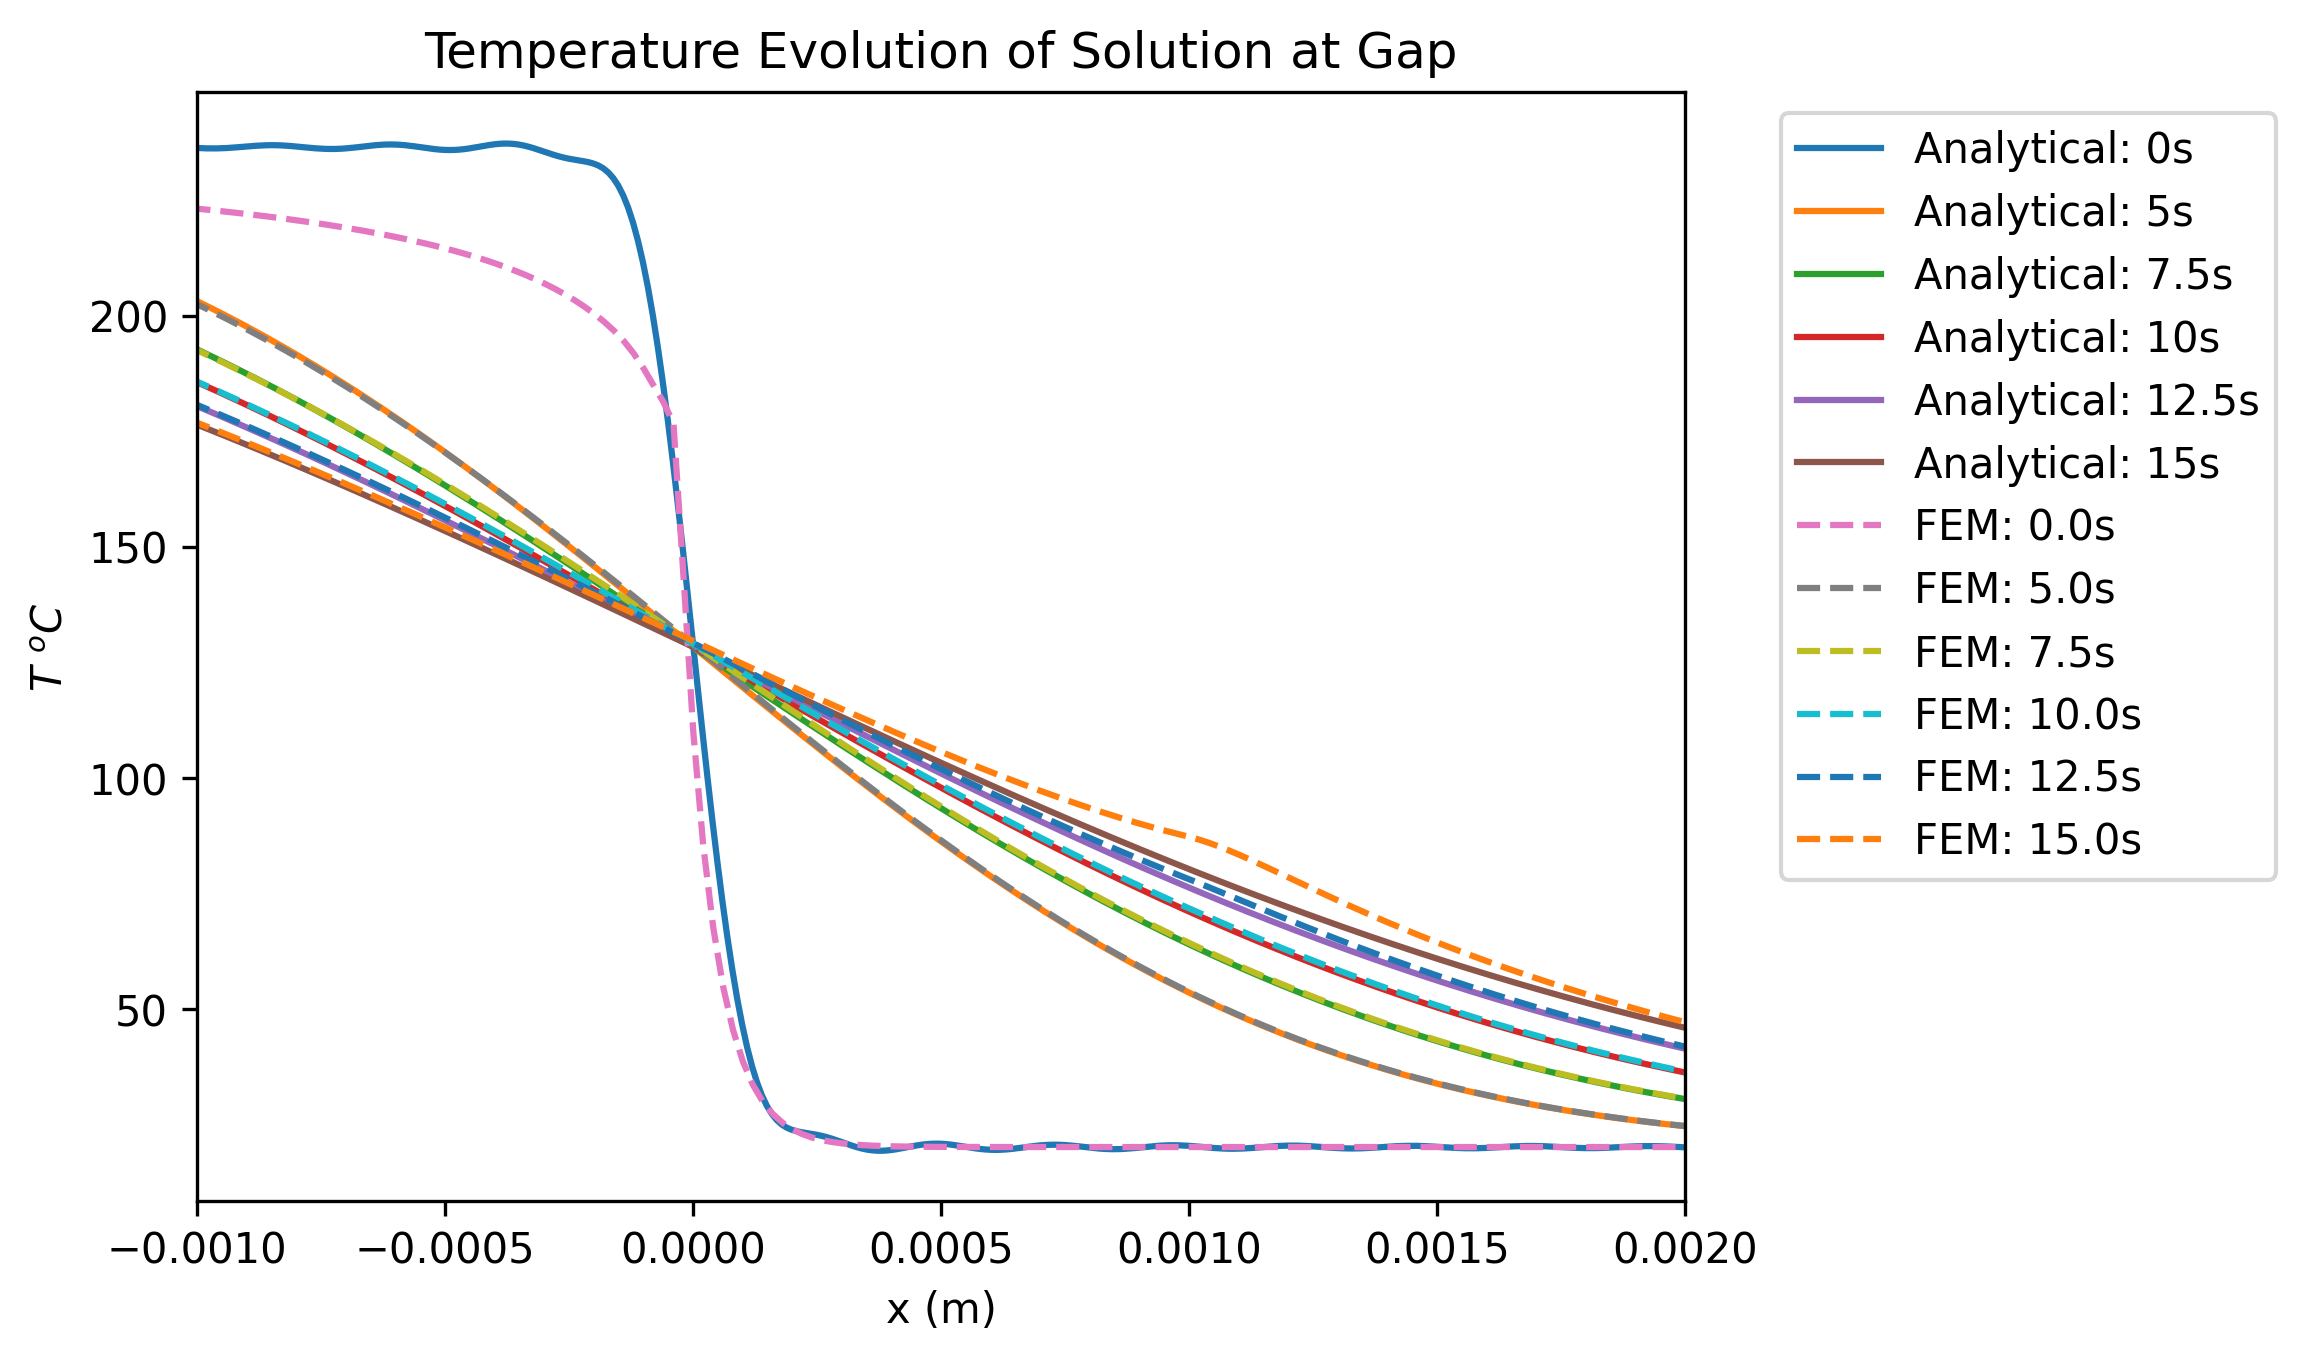

In [8]:
# Plot of temperature evolution vs x
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx
    else:
        return idx

find_first = lambda a, val, tol: next(i for i, _ in enumerate(a) if np.isclose(_, val, tol))

import glob
import sys
Tn=0
t=0
n=250

h = 0
a=kr/(rhor*Cpr)
b=h/(rhor*Cpr)

# Initial def for lambda lambdas (lol)
lmbda = lambda i, L : (((i*np.pi)/L)**2)
lmbda_n = lambda i, L, b, a : ((((i*np.pi)/L)**2)+(b/a))

# Times in seconds to plot temperature evolution
times = [0,5,7.5,10,12.5,15]
for t in times:
    Tn = 0
    for i in range(n):
        Tn += An[i]*np.cos((i*x*np.pi)/L)*np.exp(-lmbda(i,L)*a*t)
    Tn = (Tn*(np.max(T1)-(np.min(T1))))+(np.min(T1)-273)
    plt.plot(x-x_d,Tn,label=f"Analytical: {t}s")

# Times in ms to plot temperature evolution
times = [0,500,750,1000,1250,1500]
for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    if name == "data_DCPD":
        continue
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
zeroidx = find_nearest(x,0.0)
targetidx = find_nearest(x,0.001)
alpha=results_data['alpha_data'][:,zeroidx]
T = results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))
t = results_data['t_data'][:,zeroidx]
tidx = find_nearest(theta, 0.5)
for time in times:
    T = results_data['T_data'][int(t_gs*100)+time,:] - 273
    print(T[targetidx])
    x = results_data['x_data'][int(t_gs*100)+time,:]
    plt.plot(x,T,'--',label=f"FEM: {time/100}s")
plt.legend()


plt.xlim(-0.001,0.002)
plt.xlabel("x (m)")
plt.ylabel(r'$T~^oC$')
plt.title("Temperature Evolution of Solution at Gap")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

passing


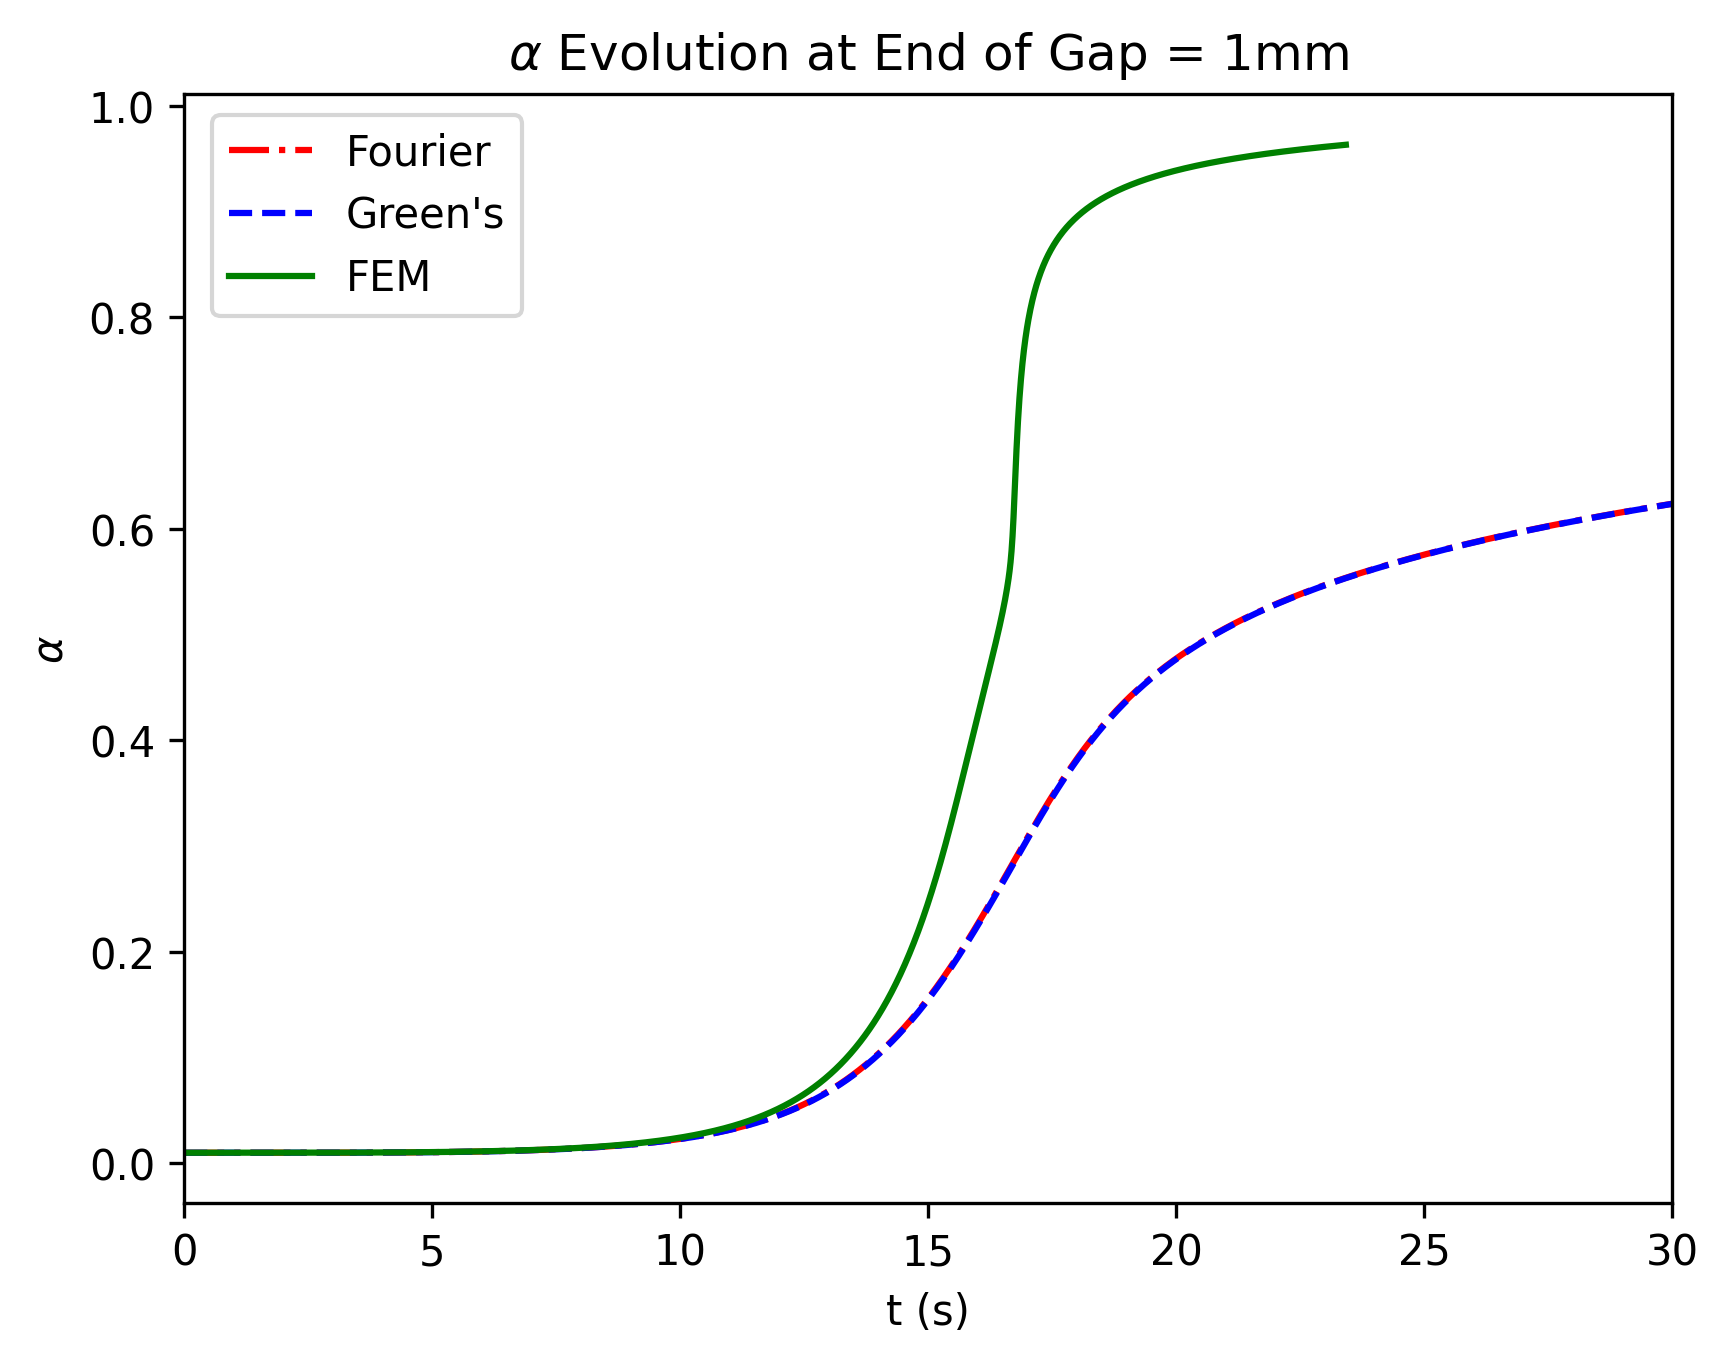

In [165]:
## THIS IS THE MASTER CELL. AFTER RUNNING ALL THE ABOVE CELLS, UNCOMMENT DESIRED PLOTS AND RUN

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx
    else:
        return idx

def fouriertemp(x,t,h):
    theta_xth = 0
    b = h/(rhor*Cpr)
    for i in range(n):
        theta_xth += An[i]*np.cos((i*x*np.pi)/L)*np.exp(-lmbda_n(i,L,b,a)*a*t)
    T_xth = theta_xth * (np.max(T1)-np.min(T1)) + np.min(T1) - 273
    return T_xth

def fouriertemp_k(x,t,h):
    theta_xth = 0
    b = h/(rhor*Cpr)
    for i in range(n):
        theta_xth += An[i]*np.cos((i*x*np.pi)/L)*np.exp(-lmbda_n(i,L,b,a)*a*t)
    T_xth = theta_xth * (np.max(T1)-np.min(T1)) + np.min(T1)
    return T_xth

def erftemp(x,t):
    return 1/2*(special.erf((-x)/(np.sqrt(4*c*(np.add(t,erft0))))) + 1)

find_first = lambda a, val, tol: next(i for i, _ in enumerate(a) if np.isclose(_, val, tol))

import glob
import sys
from scipy import special
import matplotlib.animation as animation

Tn=0
t=0
n=250
gap = 0.001
h = 0
tdiff = 0.15267863661495
a=kr/(rhor*Cpr)
b=h/(rhor*Cpr)
c = kr/(rhor*Cpr)
erft0 = 1/40

lmbda = lambda i, L : (((i*np.pi)/L)**2)
lmbda_n = lambda i, L, b, a : ((((i*np.pi)/L)**2)+(b/a))

A = 8.55e15
E = 1.1075e5
R = 8.3144621
n_g = 1.720
m_g = 0.770
c_g = 14.480
a_cg = 0.410
t_range = np.linspace(20,100,80)
alpha_o = 0.01
da_dt = []

g_a = lambda alpha : ((1-alpha)**n_g)*(alpha**m)*(1/(1+np.exp(c_g*(alpha-a_cg))))
f_a = lambda alpha : 1/(A*np.exp(-E/(R*((Hr/Cpr)*(alpha - alpha_o)+t_o)))*g_a(alpha))

# plt.axvline(x = x_d+0.00025, color = 'b', label = 'gap beginning')



# Fourier Temp vs X plot
"""
times = [0,5,7.5,10,12.5,15]
#times = [0,5,10,20,30]
for t in times:
    Tn = 0
    for i in range(n):
        Tn += An[i]*np.cos((i*x*np.pi)/L)*np.exp(-lmbda(i,L)*a*t)
    plt.plot(x-x_d,(Tn*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),label=f"Semi-Analytical: {t}s")
"""

# Fourier Temp vs Time plot
"""
tspace = np.linspace(0,40,1550)
Tn = 0
i = 0
for i in range(n):
    Tn += An[i]*np.cos((i*(x_d+gap)*np.pi)/L)*np.exp(-lmbda(i,L)*a*tspace)
plt.plot(tspace,(Tn*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),'-.',color='r',label=f"Fourier")
"""

# Fourier Alpha vs Time plot

i_n = 0
alphan = []
alpha_val = 0
t = np.linspace(0,40,10000)
dt = t[2]-t[1]

for i in t[:9999]:
    i_n += 1
    if i == 0:
        alphan.append(alpha0)
        pass
    alpha_val = alphan[i_n-1] + A*np.exp(-E/(R*(fouriertemp_k(x_d+gap,i,0)-tdiff))) * g_a(alphan[i_n-1]) * dt
    alphan.append(alpha_val)
plt.plot(t,alphan,'-.',color='r',label="Fourier")


# Greens Temp vs X plot
"""
times = [0,5,7.5,10,12.5,15]
for t in times:
    erft = erftemp(x-x_d,t)
    plt.plot(x-x_d,(erft*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),label=f"Analytical: {t}s")
plt.xlim(-0.001,0.002)
"""

# Greens Temp vs Time plot
"""
tspace = np.linspace(0,40,1550)
erft = erftemp(gap,tspace)
plt.plot(tspace,(erft*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),'--',color='b',label=f"Green's")
"""

# Greens Alpha vs Time plot

i_n = 0
alphan = []
alpha_val = 0
t = np.linspace(0,40,10000)
dt = t[2]-t[1]

for i in t[:9999]:
    i_n += 1
    if i == 0:
        alphan.append(alpha0)
        pass
    #tempval = fouriertemp_k(x_d+gap,i,0)
    tempval = erftemp(gap,i) * (np.max(T1)-np.min(T1)) + np.min(T1)
    alpha_val = alphan[i_n-1] + A*np.exp(-E/(R*(tempval-tdiff))) * g_a(alphan[i_n-1]) * dt
    alphan.append(alpha_val)
plt.plot(t,alphan,'--',color='b',label="Green's")


# Numerical Temp vs X plot
"""
times = [0,500,750,1000,1250,1500]
for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    if name == "data_DCPD":
        continue
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
zeroidx = find_nearest(x,0.0)
alpha=results_data['alpha_data'][:,zeroidx]
T = results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))
t = results_data['t_data'][:,zeroidx]
tidx = find_nearest(theta, 0.5)
t_gs=t[int(tidx)]
for time in times:
    T = results_data['T_data'][int(t_gs*100)+time,:] - 273
    x = results_data['x_data'][int(t_gs*100)+time,:]
    plt.plot(x,T,'--',label=f"FEM: {time/100}s")

plt.legend()


plt.xlim(-0.001,0.002)
plt.xlabel("x (m)")
plt.ylabel(r'$T~^oC$')
plt.title("Temperature Evolution of Solution for Gap = 1mm")
"""

# Numerical Temp vs Time plot
"""
for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    if name == "data_DCPD":
        continue
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
idx = find_nearest(x,float(gaplen))
zeroidx = find_nearest(x,0.0)
T=results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))

shift = find_nearest(theta,0.5)

T=results_data['T_data'][:,idx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))
t=results_data['t_data'][:,idx]
targettime = find_nearest(t - t[shift], 5)

plt.plot(t-t[shift],T,color='g',label="FEM")
plt.xlim(0,30)
plt.xlabel("t (s)")
plt.ylabel(r'$T~^oC$')
plt.title("Temperature Evolution at End of Gap = 1mm")
"""

# Numerical Alpha vs Time plot

for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    if name == "data_DCPD":
        print("passing")
        continue
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
idx = find_nearest(x,float(gaplen))
zeroidx = find_nearest(x,0.0)
T=results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))

shift = find_nearest(theta,0.5)

t=results_data['t_data'][:,idx]
alpha=results_data['alpha_data'][:,idx]

plt.plot(t-t[shift],alpha,color='g',label="FEM")
plt.xlim(0,30)
plt.xlabel("t (s)")
plt.ylabel(r'$\alpha$')
plt.title(r"$\alpha$ Evolution at End of Gap = 1mm")


plt.legend(bbox_to_anchor=(0.005, 1.0), loc='upper left')

started :/


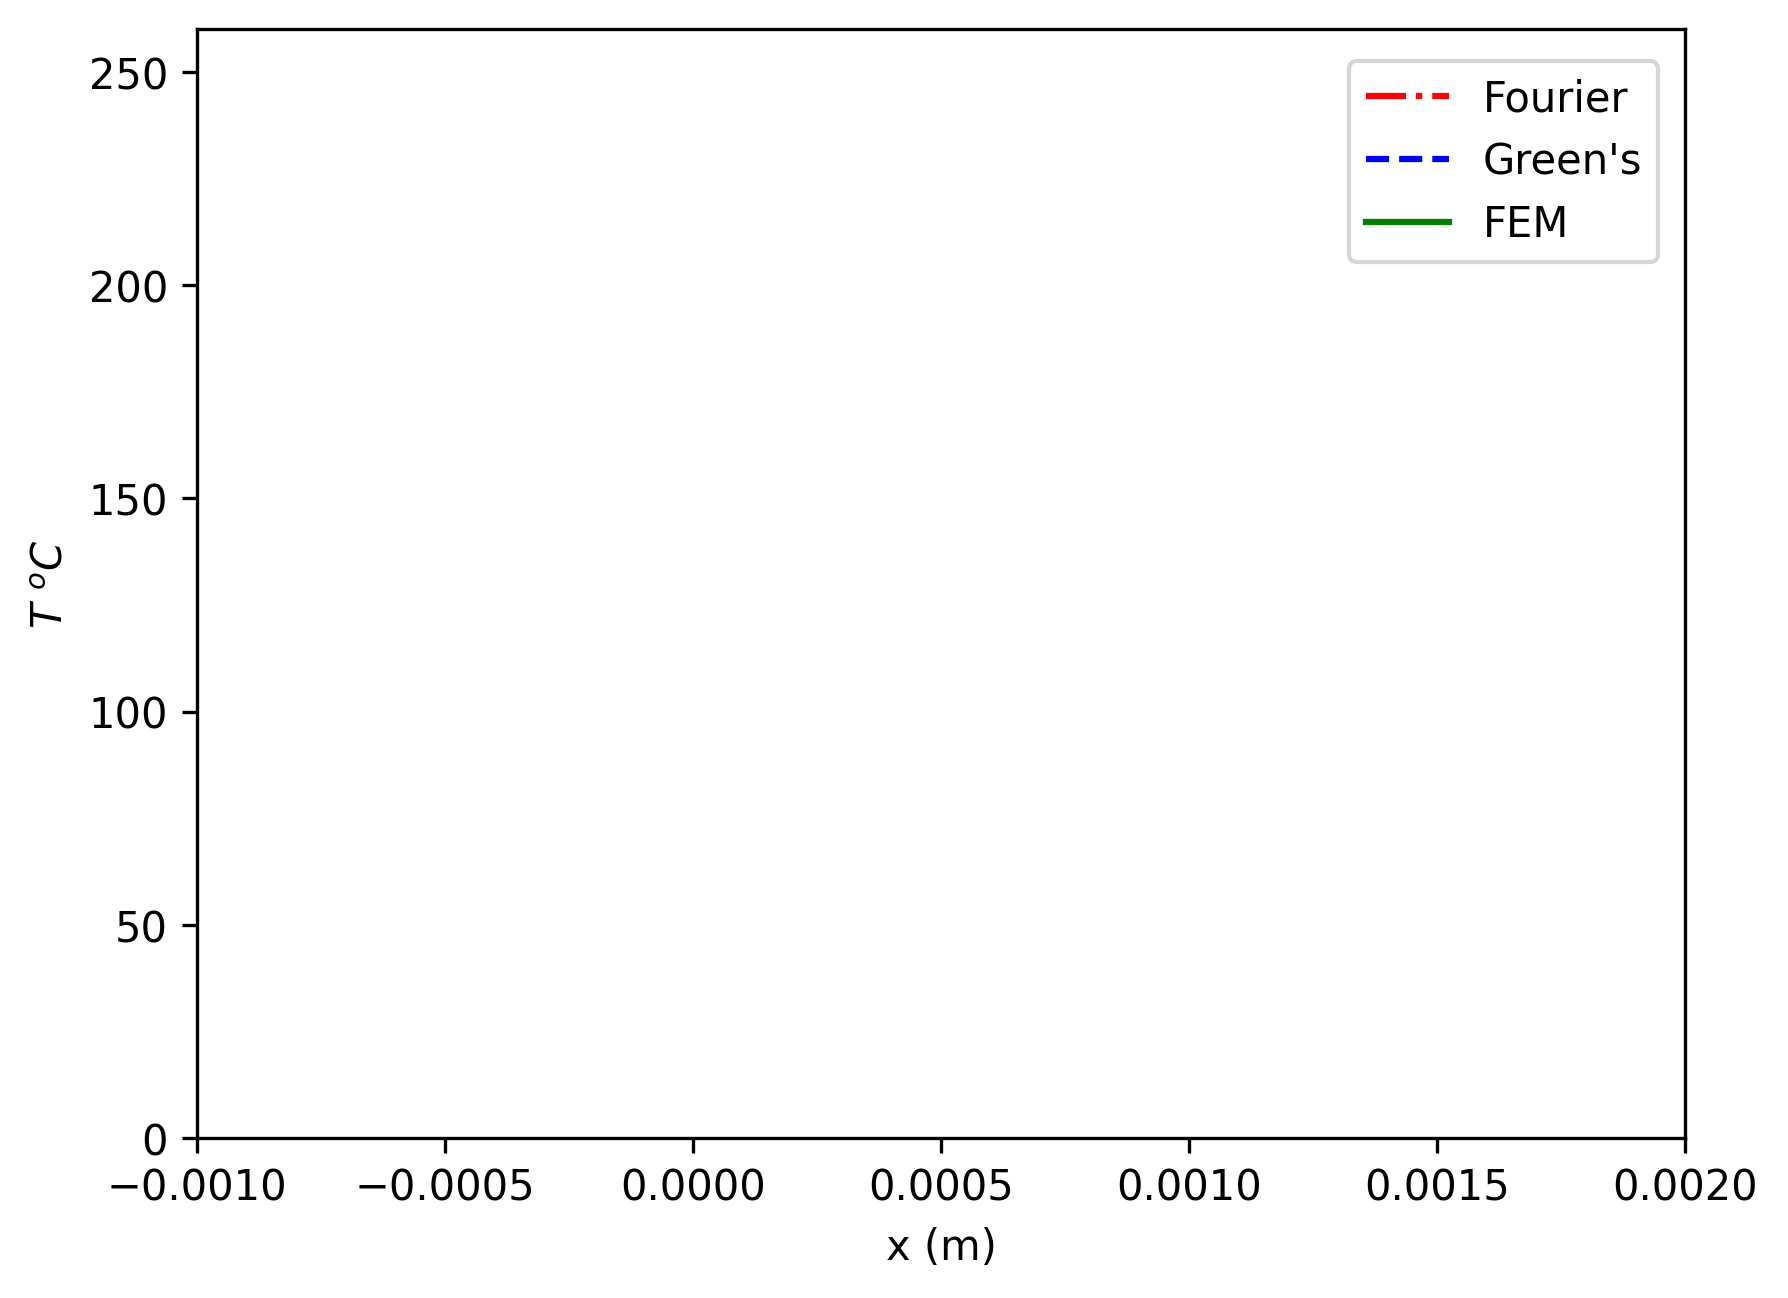

In [156]:
## This cell is for animating the temperature evolution. 
## There is likely some overlap with the above cell that could be cut down

import glob
import sys
from scipy import special
import matplotlib.animation as animation

Tn=0
t=0
n=250
gap = 0.001
h = 0
tdiff = 0.15267863661495
a=kr/(rhor*Cpr)
b=h/(rhor*Cpr)
c = kr/(rhor*Cpr)
erft0 = 1/40

lmbda = lambda i, L : (((i*np.pi)/L)**2)
lmbda_n = lambda i, L, b, a : ((((i*np.pi)/L)**2)+(b/a))

A = 8.55e15
E = 1.1075e5
R = 8.3144621
n_g = 1.720
m_g = 0.770
c_g = 14.480
a_cg = 0.410
t_range = np.linspace(20,100,80)
alpha_o = 0.01
da_dt = []

g_a = lambda alpha : ((1-alpha)**n_g)*(alpha**m)*(1/(1+np.exp(c_g*(alpha-a_cg))))
f_a = lambda alpha : 1/(A*np.exp(-E/(R*((Hr/Cpr)*(alpha - alpha_o)+t_o)))*g_a(alpha))

# plt.axvline(x = x_d+0.00025, color = 'b', label = 'gap beginning')


for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    if name == "data_DCPD":
        continue
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
zeroidx = find_nearest(x,0.0)
alpha=results_data['alpha_data'][:,zeroidx]
T = results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))
time = results_data['t_data'][:,zeroidx]
tidx = find_nearest(theta, 0.5)
t_gs=time[int(tidx)]

# Animation container setup
fig = plt.figure(0)
ax = fig.add_subplot()
ax.set_xlabel('x (m)')
ax.set_ylabel(r'$T~^oC$')
ax.set_xlim(-0.001,0.002)
ax.set_ylim(0,260)
ims = []

frames = np.linspace(0,20,1000)
print("started :/")
for t in frames:
    # Animation setup

    currim = []
    
    # Analytical Temp vs X plot
    Tn = 0
    for i in range(n):
        Tn += An[i]*np.cos((i*x*np.pi)/L)*np.exp(-lmbda(i,L)*a*t)
    im, = ax.plot(x-x_d,(Tn*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),'-.',color='r',label=f"Fourier")
    currim.append(im)
    
    # Matthew Temp vs X plot
    erft = erftemp(x-x_d,t)
    im, = ax.plot(x-x_d,(erft*(np.max(T1)-(np.min(T1)))+(np.min(T1)-273)),'--',color='b',label=f"Green's")
    currim.append(im)
    
    # Numerical Temp vs X plot
    T = results_data['T_data'][int(t_gs*100+(t*100)),:] - 273
    x = results_data['x_data'][int(t_gs*100+(t*100)),:]
    im, = ax.plot(x,T,color='g',label=f"FEM")
    currim.append(im)
    
    title = ax.text(0.5, 1.025, "Temperature Evolution for Gap = 1mm", ha="center", size=plt.rcParams["axes.titlesize"],transform=ax.transAxes,)
    currim.append(title)
    time = ax.text(0.5, 0.95, "time = {:.2f}s".format(t), ha="center",transform=ax.transAxes,)
    currim.append(time)
    
    ims.append(currim)
ax.legend(handles=ims[0][:3], bbox_to_anchor=(.76, .99), loc='upper left')
ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False)
save_path = os.path.join(save_dir, "animation.mp4")
ani.save(save_path, writer='ffmpeg')

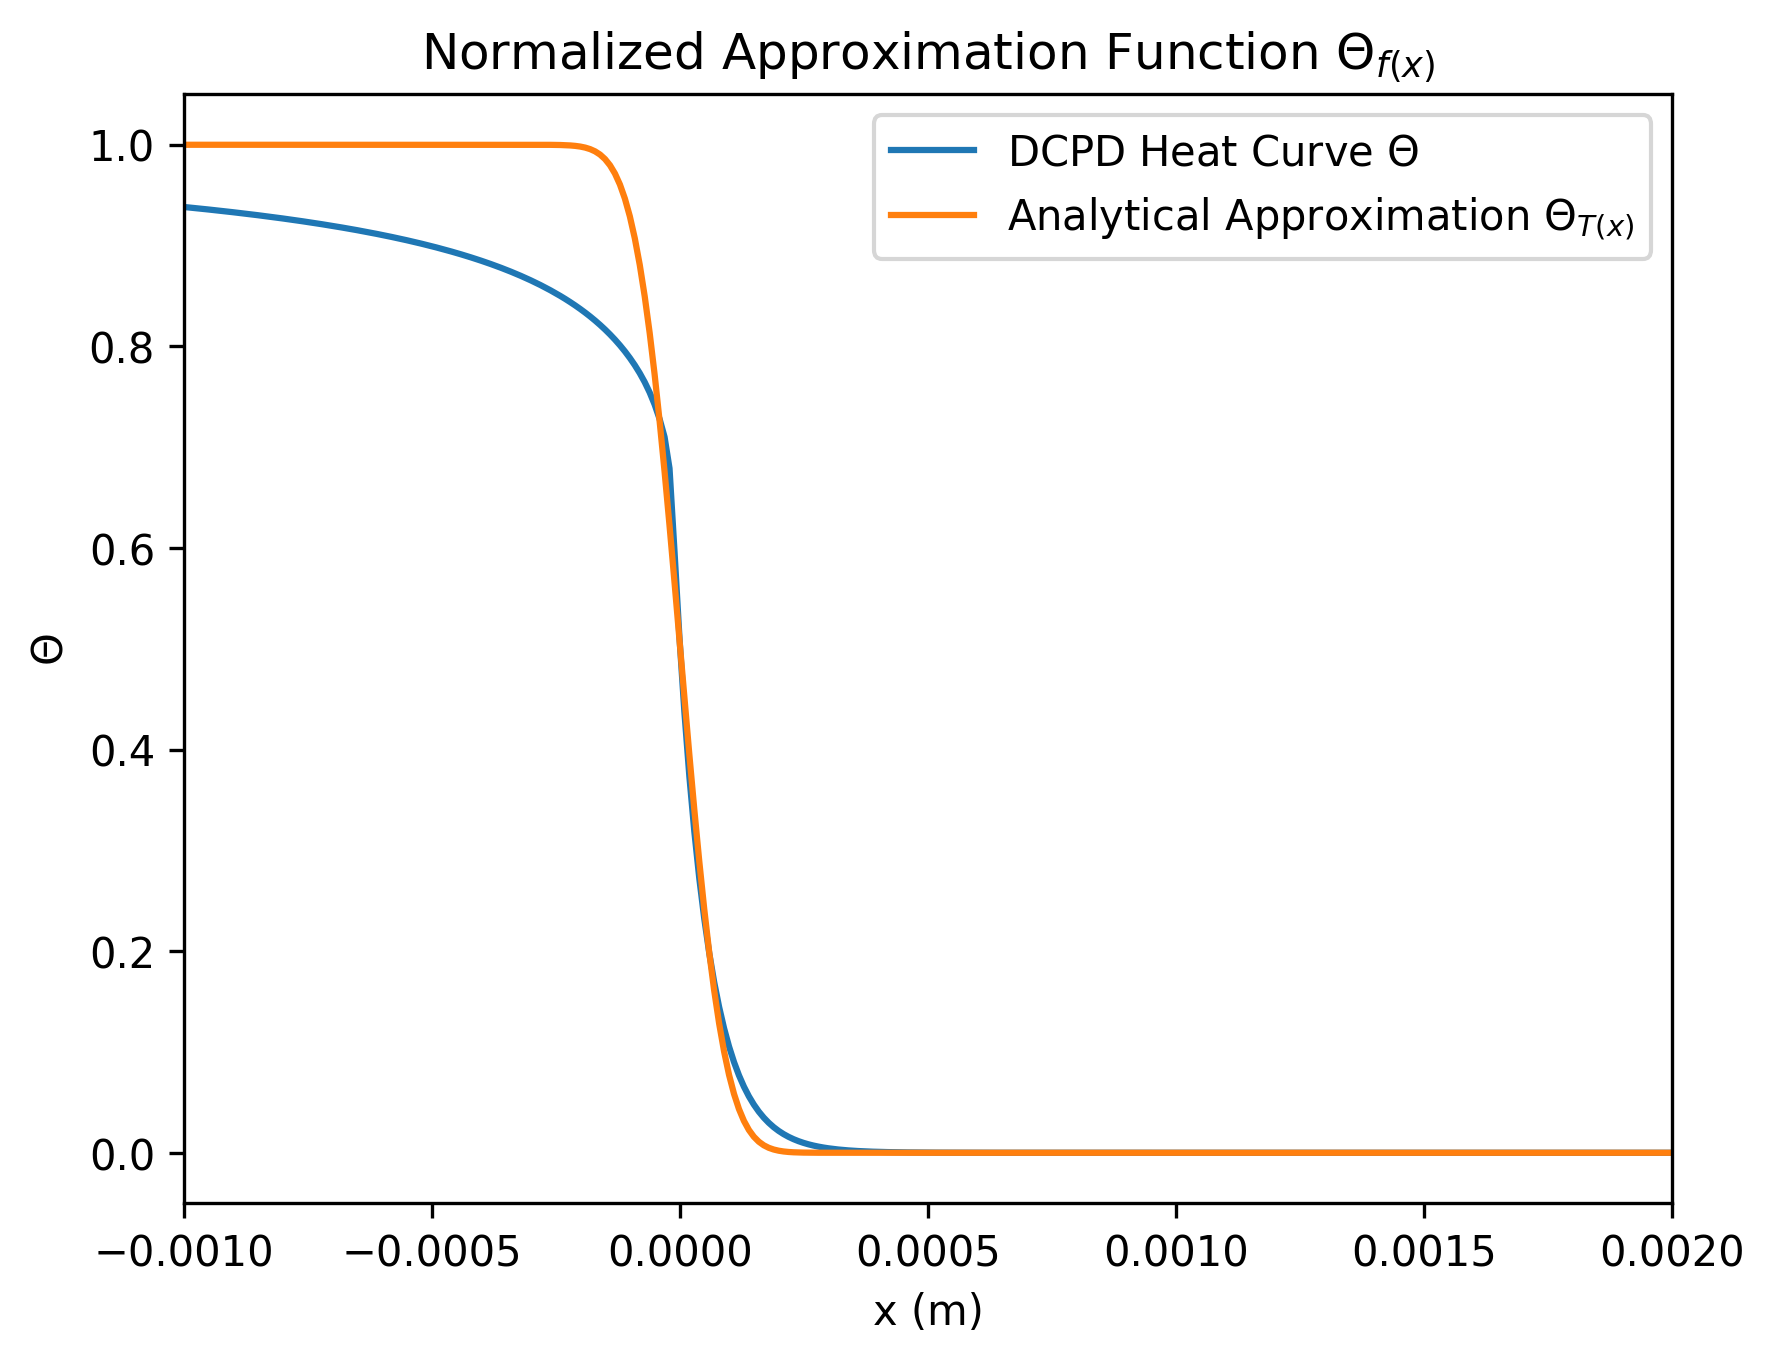

In [60]:
# Use this cell to tune green's initial condition.

results_data = loadResults(save_dir, "data_DCPD")  # load from .mat file
T=results_data['T_data']
T1=T[300,:]
x=results_data['x_data'][300,:]
# define normalized curve
theta=(T1-np.min(T1))/(np.max(T1)-np.min(T1))
plt.plot(x-x_d,theta,label=r"DCPD Heat Curve ${\Theta}$")

erft0 = 1/40
erft = erftemp(x-x_d,0)
plt.plot(x-x_d,(erft),label=r"Analytical Approximation ${\Theta}_{T(x)}$")
plt.xlim(-0.001,0.002)

plt.xlabel("x (m)")
plt.ylabel(r"${\Theta}$")
plt.title(r"Normalized Approximation Function ${\Theta}_{f(x)}$")
plt.legend()

In [77]:
# Redef constants for next section
A = 8.55e15
E = 1.1075e5
R = 8.3144621
n_g = 1.720
m_g = 0.770
c_g = 14.480
a_cg = 0.410
t_range = np.linspace(20,100,80)
alpha_o = 0.01
da_dt = []

# Lambda's for g(alpha) and f(alpha)
g_a = lambda alpha : ((1-alpha)**n_g)*(alpha**m)*(1/(1+np.exp(c_g*(alpha-a_cg))))
f_a = lambda alpha : 1/(A*np.exp(-E/(R*((Hr/Cpr)*(alpha - alpha_o)+t_o)))*g_a(alpha))

Text(0.5, 1.0, 'Adiabatic Temperature Evolution for Varying Gap Size')

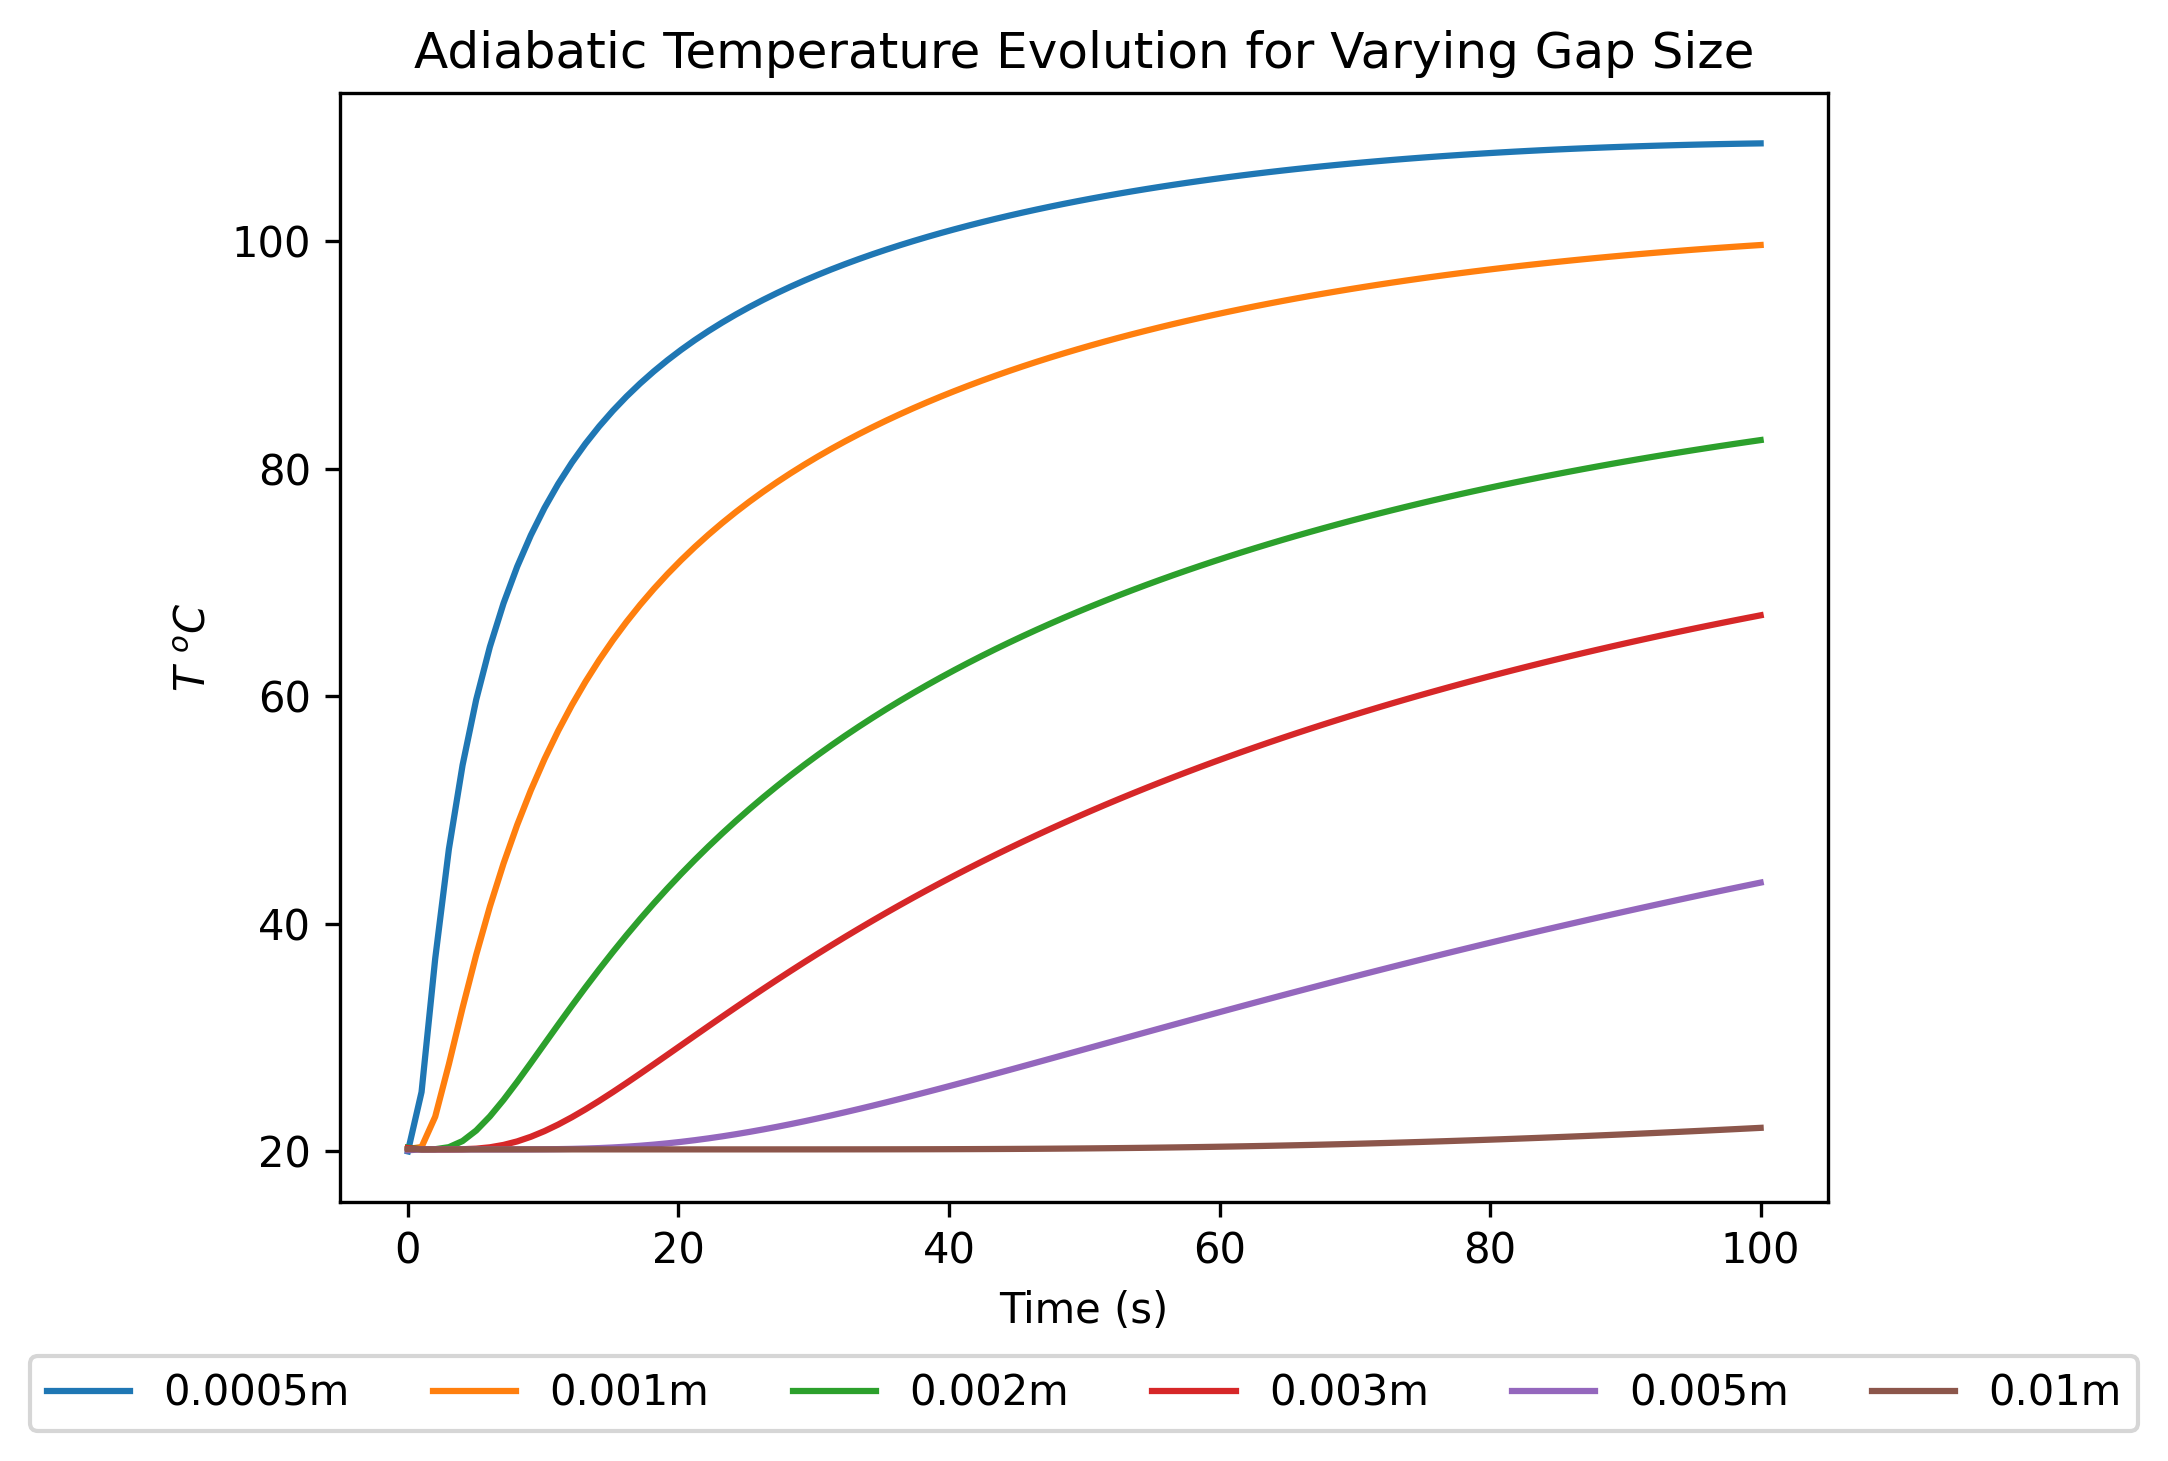

In [113]:
# Temp evolution for varying gap size
from fractions import Fraction
gaps = [0.0005, 0.001, 0.002, 0.003, 0.005, 0.01]
t = np.linspace(0,100,100)
Tf = np.min(T1) + (Hr*(1-alpha0)/Cpr)
D = kr/(rhor*Cpr)
vc = (((A*kr*R*(Tf**2))/(rhor*Hr*(1-alpha0)*E)) * np.exp((-E)/(R*Tf)))**0.5
lc = D/(vc)


temp = []
for gap in gaps:
    temp.append(fouriertemp(gap+x_gs, t, 0*kr/(lc**2)))
    plt.plot(t,temp[0],label=f"{gap}m")
#    plt.plot(t,temp[0],label=r"gapsize=$\frac{{1}}{{{}}}$m".format(1/gap))
#    plt.plot(t,temp[0],label=r"$h_l$=" + f"{h/kl:.1f}" + r"$\kappa/L^2$" + r'$\frac{W}{m^3K}$')    
    temp = []
    
plt.xlabel("Time (s)")
plt.ylabel(r'$T~^oC$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6)
plt.title(r"Adiabatic Temperature Evolution for Varying Gap Size")

In [ ]:
# This is a very long running time. This cell generates and saves results
# for the endgame plot of cross time vs gap size for varying heat loss

# Constants and data setup
g_a = lambda alpha : ((1-alpha)**n_g)*(alpha**m)*(1/(1+np.exp(c_g*(alpha-a_cg))))
gaps = np.linspace(0,0.005,501)
kl = kr/(L**2)
hs = [0, 1/250000, 1/500000, 1/1000000, 1/2000000, 1/3000000, 1/50000000]
timespace = np.linspace(0,260,10000)
dt = timespace[2]-timespace[1]
tdiff = 0.15267863661495
t0s = [0,10,20,30]
alpha0 = 0.01
alphan = []
i_n = 0
t_sl = []
# Tf is working in kelvins
Tf = np.min(T1) + (Hr*(1-alpha0)/Cpr)
D = kr/(rhor*Cpr)
vc = (((A*kr*R*(Tf**2))/(rhor*Hr*(1-alpha0)*E)) * np.exp((-E)/(R*Tf)))**0.5
lc = D/(vc)
print(lc)

# Manually set this dict to the same values as your h constants
data_save = {0:[], 1/250000:[], 1/500000:[], 1/1000000:[], 1/2000000:[], 1/3000000:[], 1/50000000:[]}

tn = 0
# i is always t
for h in hs: 
    for gap in gaps:
        for i in timespace[:9999]:
            # to prevent divide by zero
            if gap == 0:
                hcurr = 0
            else:
                hcurr = (h*kr/(lc**2))
            i_n += 1
            if i == 0:
                alphan.append(alpha0)
                pass
            alpha_val = alphan[i_n-1] + A*np.exp(-E/(R*(fouriertemp_k(x_d+gap,i,hcurr)-tdiff+tn))) * g_a(alphan[i_n-1]) * dt
            alphan.append(alpha_val)
        # Choose this value as gap restart alpha value, ie at alpha=0.25 gap is crossed
        t_sl.append(np.interp(0.25,alphan,timespace))
        data_save[h].append([gap, np.interp(0.25,alphan,timespace)])
        alphan = []
        i_n = 0
    #plt.plot(gaps,t_sl,label=r"$h_l$=" + f"{h/kl:.1f}" + r"$\kappa/L^2$" + r'$\frac{W}{m^3K}$')
    if h == 0:
        plt.plot(gaps,t_sl,label="Adiabatic")
    else:
        plt.plot(gaps,t_sl,label=r"$h_l$=" + r"$\frac{{1}}{{{:.1e}}}$".format(int(1/h)) + r"$\kappa/L_c^2$")
    t_sl = []
plt.title("Gap Cross Time for Varying Heat Loss")
plt.xlabel("Gap Size (m)")
plt.ylabel(r'$t_{sl}$ (s)')
plt.ylim(0,250)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

5.269650975262766e-06


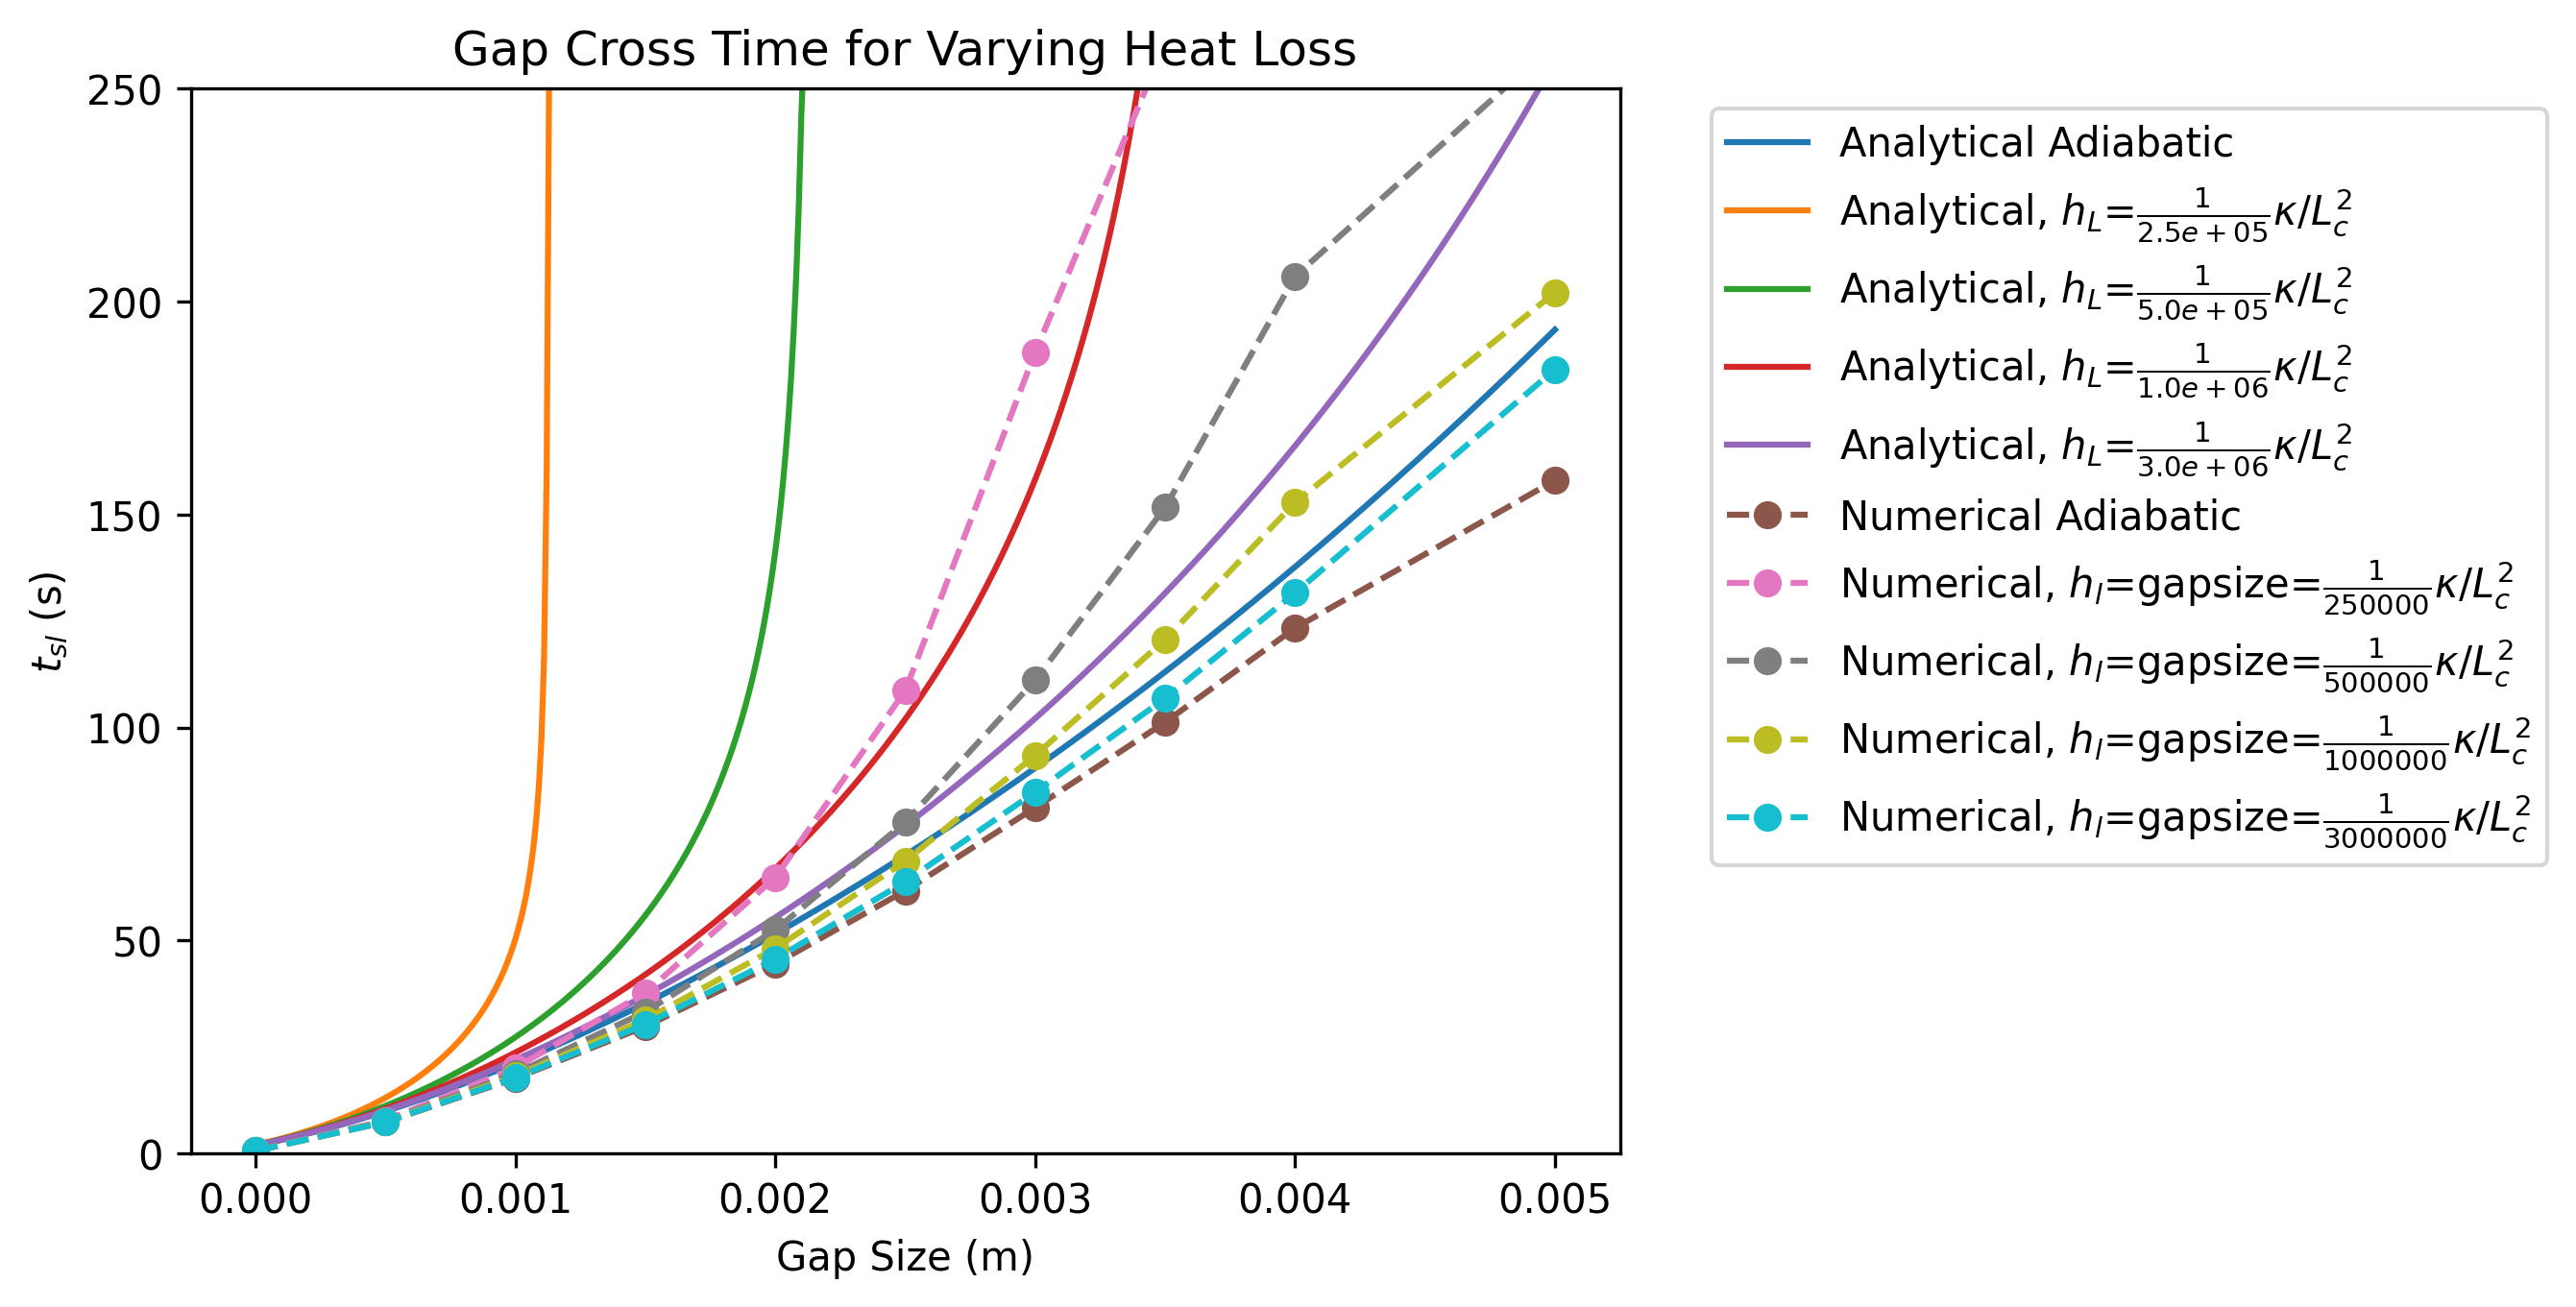

In [251]:
# I'll process in this one
import glob
hs = [0, 1/250000, 1/500000, 1/1000000, 1/3000000]

for h in hs:
    # Zip arrays so that matplotlib likes the format
    x,y = zip(*data_save[h])
    if h == 0:
        plt.plot(x,y,label=f"Analytical Adiabatic")
    else:
        plt.plot(x,y,label=r"Analytical, $h_L$=" + r"$\frac{{1}}{{{:.1e}}}$".format(int(1/h)) + r"$\kappa/L_c^2$")
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx
    else:
        return idx

# Again, make sure this dict matches your h values
proc_data = {0:[], 250000:[], 500000:[], 1000000:[], 2000000:[], 3000000:[], 50000000:[]}

# Read from generated FEM results and plot interp'd alpha values
for file in glob.iglob(str(save_dir) + "/*.mat"):
    name = file[9:-4]
    gaplen,hval = file[14:-4].split("_")
    if hval == "0":
        results_data = loadResults(save_dir, name)
        gaplen = str(float(gaplen) / 1e3)
        if gaplen == "0.0045":
            continue
        elif float(gaplen) <= 0.005:
            x = results_data['x_data'][0,:]
            idx = find_nearest(x,float(gaplen))
            alpha=results_data['alpha_data'][:,idx-1]
            t=results_data['t_data'][:,idx-1]
            halftime = np.interp(0.25,alpha,t)
            data_point = [float(gaplen), halftime - 9.25]
            proc_data[int(hval)].append(data_point)
    elif 1/float(hval) in hs:
        results_data = loadResults(save_dir, name)
        gaplen = str(float(gaplen) / 1e3)
        if gaplen == "0.0045":
            continue
        if float(gaplen) <= 0.005:
            x = results_data['x_data'][0,:]
            idx = find_nearest(x,float(gaplen))
            alpha=results_data['alpha_data'][:,idx-1]
            t=results_data['t_data'][:,idx-1]
            halftime = np.interp(0.25,alpha,t)
            data_point = [float(gaplen), halftime - 9.25]
            proc_data[int(hval)].append(data_point)

# Read from previous cell's data structure and plot analytical alpha time
# If changed anything, must rerun previous cell
for h in hs:
    if h == 0:
        proc_data[0].sort()
        if not bool(proc_data[0]):
            continue
        x,y = zip(*proc_data[0])
        plt.plot(x,y,label=f"Numerical Adiabatic",linestyle="dashed",marker="o")
    else:
        proc_data[int(1/h)].sort()
        if not bool(proc_data[int(1/h)]):
            continue
        x,y = zip(*proc_data[int(1/h)])
        plt.plot(x,y,label=r"Numerical, $h_l$=" + r"gapsize=$\frac{{1}}{{{}}}$".format(int(1/h)) + r"$\kappa/L_c^2$",linestyle="dashed",marker="o")
plt.title("Gap Cross Time for Varying Heat Loss")
plt.xlabel("Gap Size (m)")
plt.ylabel(r'$t_{sl}$ (s)')
plt.ylim(0,250)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')